### Qiitaより

[画像処理でコンクリートのひび割れ抽出](https://qiita.com/ground0state/items/072468b2b14523d91293)

In [2]:
import cv2
import random
import numpy as np
from skimage.feature import hessian_matrix
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid


def show_imgs(imgs_dict:dict, ncol=0, dpi=200, font_scale=0.7):
    font_size = int(plt.rcParams["font.size"]*font_scale)

    if ncol > 0:
        nrow = ((len(imgs_dict)-1)//ncol)+1
    else:
        nrow = 1
        ncol = len(imgs_dict)

    img_num = len(imgs_dict)
    fig = plt.figure(figsize=(float(img_num), float(img_num)), dpi=dpi)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrow, ncol), axes_pad=0.2,)

    for i in range(nrow*ncol):
        grid[i].axis('off')
        if i < len(imgs_dict):
            img_key = list(imgs_dict.keys())[i]
            grid[i].imshow(cv2.cvtColor(imgs_dict[img_key], cv2.COLOR_BGR2RGB))
            grid[i].set_title(img_key, fontsize=font_size, color='black', pad=int(font_size/2))
    
    plt.show(); plt.close()
    return None


def imread(filename):
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def image_correction(img):
    """濃淡差や影を補正する."""
    img = cv2.GaussianBlur(img, (7, 7), 0)
    return img


def calc_hessian(img, sigma):
    Hxx, Hxy, Hyy = hessian_matrix(
        img, sigma=sigma, mode='mirror', order='xy',
        use_gaussian_derivatives=False)
    hessian = np.stack( [Hxx, Hxy, Hxy, Hyy],
                        axis=2).reshape(*img.shape, 2, 2)
    return hessian


def hessian_emphasis(img, sigma=1.414, alpha=0.25):
    hessian = calc_hessian(img, sigma)
    eig_val, _ = np.linalg.eig(hessian)

    r = np.zeros_like(img, dtype=np.float64)
    for i in range(hessian.shape[0]):
        for j in range(hessian.shape[1]):
            # 各画素の固有値を取得
            lambda1, lambda2 = eig_val[i, j]

            # 小さい方をlambda2にする
            if lambda2 > lambda1:
                temp = lambda1
                lambda1 = lambda2
                lambda2 = temp
            if lambda1 <= 0:
                # 粒状構造
                lambda12 = abs(lambda2) + lambda1
            elif lambda2 < 0 < lambda1 < (abs(lambda2) / alpha):
                # 線状構造
                lambda12 = abs(lambda2) - lambda1 * alpha
            else:
                lambda12 = 0
            r[i, j] = sigma**2 * lambda12
    return r


def multiscale_hessian_emphasis(
        img,
        sigma=1.414,
        alpha=0.25,
        s=1.414,
        num_iteration=4
):
    R = []
    for i in range(num_iteration):
        r = hessian_emphasis(img, sigma=sigma * s**i, alpha=alpha)
        R.append(r)
    R = np.stack(R, axis=0)

    out = np.max(R, axis=0)
    out_scale = np.argmax(R, axis=0) + 1  # scaleを1から始める
    return out, out_scale


def stochastic_relaxation_method(img, alpha=1.0):
    """確率的弛緩法.

    Parameters
    ----------
    img : ndarray
        画素値は0-1に規格化.
        ひびの方が背景よりも輝度が高い.
    alpha : float
        補正用の重み.

    Returns
    -------
    out
        確率的弛緩法を適用後の画像.
    residual
        確率的弛緩法適用前後の2乗誤差.
    """
    P_c = np.log1p(img) / np.log1p(img.max())
    P_b = 1 - P_c

    kernels = [
        np.array([[0, 1, 0], [0, 1, 0], [0, 1, 0]]) / 3,
        np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]) / 3,
        np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]]) / 3,
        np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) / 3
    ]

    Q_c = []
    for kernel in kernels:
        q = cv2.filter2D(P_c, -1, kernel, borderType=cv2.BORDER_DEFAULT)
        Q_c.append(q)
    Q_c = np.stack(Q_c, axis=0)
    Q_b = 1 - Q_c

    P_c_new = np.divide(
        alpha * P_c[None, ...] * Q_c,
        alpha * P_c[None, ...] * Q_c + P_b[None, ...] * Q_b,
        where=P_c[None, ...] * Q_c + P_b[None, ...] * Q_b != 0)

    out = np.max(P_c_new, axis=0)
    return out


def stepwise_threshold_processing(
        img, candidate,
        iter_stp=3,
        k_size=21,
        element=None):

    height, width = img.shape
    if element is None:
        element = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], np.uint8)

    completed = set()
    t = b = r = l = int((k_size - 1) * 0.5)
    for _ in range(iter_stp):
        flag_updated = False
        # 候補領域の外周の位置インデックスを得る
        dilated = cv2.dilate(candidate, element, iterations=1)
        outline = dilated - candidate
        ys, xs = (outline == 1).nonzero()

        result = candidate.copy()
        for x, y in zip(xs, ys):
            if (x, y) in completed:
                # 判定済み領域は除く
                continue
            # 注目画素近傍で大津の二値化のしきい値を求める
            xmin = max(x - l, 0)
            xmax = min(x + r + 1, width)
            ymin = max(y - t, 0)
            ymax = min(y + b + 1, height)
            patch = img[ymin:ymax, xmin:xmax]
            patch_candidate = candidate[ymin:ymax, xmin:xmax]

            if crack_judge(img, (x, y), patch, patch_candidate):
                # しきい値以上であれば新たな候補領域にする
                result[y, x] = 1.0
                flag_updated = True
            else:
                # しきい値未満で背景に確定する
                completed.add((x, y))

        candidate = result.copy()
        if not flag_updated:
            break
    return result


def trans2uint(img):
    img = ((img - img.min()) * (1 / (img.max() - img.min()) * 255)).astype('uint8')
    return img


def extract_crack_mean(patch, patch_candidate):
    mu_c = np.mean(patch[patch_candidate == 1])
    mu_b = np.mean(patch[patch_candidate == 0])
    return mu_c, mu_b


def crack_judge(img, coor, patch, patch_candidate, beta=0.9):
    x, y = coor
    mu_c, mu_b = extract_crack_mean(patch, patch_candidate)
    res = (abs(img[y, x] - mu_c) / abs(img[y, x] - mu_b + 1e-9) * beta) <= 1.0
    return res


def binarization(img):
    img = ((img - img.min()) * (1 / (img.max() - img.min()) * 255)).astype('uint8')
    _, res = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return res


def crack_segmentation(
    img,
    iter_mhe=4,
    iter_srm=2,
    iter_stp=10
):
    # ヘッシアンの固有値別に画像を補正
    img, _ = multiscale_hessian_emphasis(
        img,
        num_iteration=iter_mhe
    )
    emphasis_img = img.copy()
    emphasis_img = trans2uint(emphasis_img)

    # 確率的弛緩法でノイズを消す
    kernel = np.ones((5, 5), np.float32)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    for _ in range(iter_srm):
        img = stochastic_relaxation_method(img, 2.0)

    # 抽出候補を二値画像として得る
    candidate = binarization(img)
    candidate = candidate.astype(np.float32) / 255

    # 消しすぎた候補領域を段階的閾値処理で拡張する
    mask = stepwise_threshold_processing(
        emphasis_img, candidate, iter_stp=iter_stp, k_size=27)

    # 二値化
    mask = binarization(mask)
    return mask


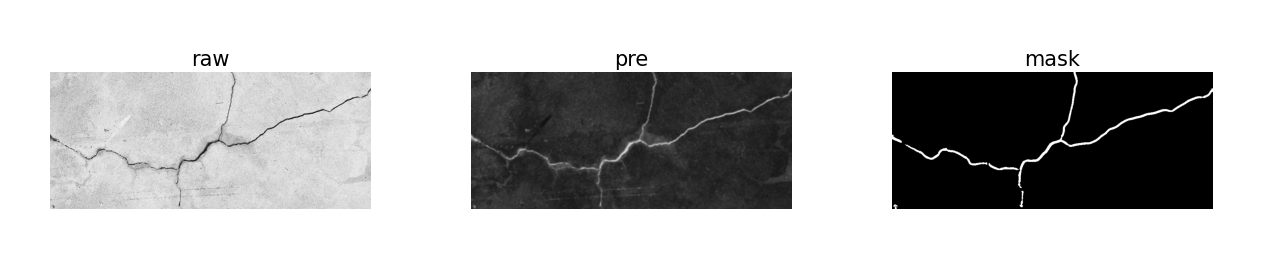

In [3]:
def main():
    
    imgs = {}
    
    # 画像の読み込み
    imgs["raw"] = imread('../sample_data/concrete_sample.jpeg')

    # 画像の前処理
    imgs["pre"] = image_correction(imgs["raw"])
    imgs["pre"] = cv2.bitwise_not(imgs["pre"])
    
    # セグメンテーション
    imgs["mask"] = crack_segmentation(imgs["pre"])

    # 結果の表示
    show_imgs(imgs, dpi=500, font_scale=0.3)

if __name__ == '__main__':
    main()


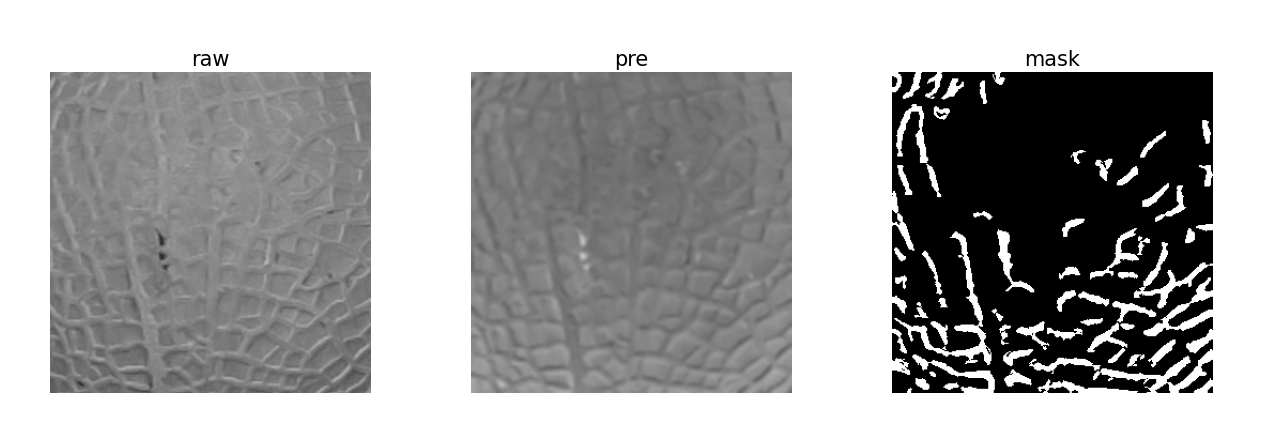

In [30]:
def main():
    
    imgs = {}
    data_dir = Path('../sample_data/melon')
    
    # 画像の読み込み
    imgs["raw"] = imread(str(random.choice(list(data_dir.glob('*.jpg')))))

    # 画像の前処理
    imgs["pre"] = image_correction(imgs["raw"])
    imgs["pre"] = cv2.bitwise_not(imgs["pre"])
    
    # セグメンテーション
    imgs["mask"] = crack_segmentation(imgs["pre"])

    # 結果の表示
    show_imgs(imgs, dpi=500, font_scale=0.3)

if __name__ == '__main__':
    main()
